# 4. Supervised Leanring Model
0. Import libraries and dataset
1. data preprocess labelled data
2. Training the Superivised Learning model 
3. Create TFIDF vectoriser from literatures that are included in the dataset
4. Cross Validation and Model Selection
5. Evaluation of Linear Support Vector Classifier

## 4.0. Import Libararies and Dataset

In [1]:
# Import all the required Library
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import operator
import matplotlib.pyplot as plt
# Text preprocessing libraries
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
nltk.download('wordnet') 
from nltk.stem.wordnet import WordNetLemmatizer

# Training and Testing Data
from sklearn.model_selection import train_test_split
# libraries for keyword extraction with tf-idf
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_selection import chi2

# Naive Bayes Classifier
from sklearn.naive_bayes import MultinomialNB

# Logistic Regression Model
from sklearn.linear_model import LogisticRegression

# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

# support Vector Classifier
from sklearn.svm import LinearSVC

# Cross validation library
from sklearn.model_selection import cross_val_score

# Generating confusion matrix library
from sklearn.metrics import confusion_matrix

# Plotting cross validation graph
import seaborn as sns


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\josep\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\josep\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\josep\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Import the pickle files created from previous notebooks
scoped_categorised_literature = pd.read_pickle("./1_scoped_cat_lit.pkl")
extracted_literature_data = pd.read_pickle("./2_extracted_literature_data.pkl")
print(scoped_categorised_literature.columns)

Index(['Date', 'topic_id', 'research_topic', 'pdf_json_files',
       'pmc_json_files', 'Study', 'Study Link', 'Journal', 'Study Type',
       'Factors', 'Influential', 'Excerpt', 'Measure of Evidence', 'Added on'],
      dtype='object')


In [3]:
# Creating a list of all the topics with their topic_id
topic_list = scoped_categorised_literature[['topic_id', 'research_topic']].drop_duplicates()
print(topic_list)

    topic_id                                     research_topic
1          1  Effectiveness of a multifactorial strategy to ...
0          2  Effectiveness of case isolation_isolation of e...
0          3       Effectiveness of community contact reduction
0          4    Effectiveness of inter_inner travel restriction
0          5                 Effectiveness of school distancing
1          6  Effectiveness of workplace distancing to preve...
10         7  Evidence that domesticated_farm animals can be...
0          8  How does temperature and humidity affect the t...
0          9  Methods to understand and regulate the spread ...
0         10                        Seasonality of transmission
0         11  What is the likelihood of significant changes ...


In [4]:
# Printing Sample Text Extractions that are labelled
for index, row in scoped_categorised_literature.iterrows():
    print(index, '_____________________________')
    print(row['Excerpt'])

1 _____________________________
Comparing these four scenarios, we shall deduce that, in order to be effective in containing the outbreak, the lockdown shall address at least 80% of the population reducing their contact rate to about 30% of their usual contacts
2 _____________________________
Our study reveals that the strict control measures implemented in India substantially mitigated the disseminate of SARS-CoV-2. Importantly, model simulations predict that 95% reduction of outbreak on June 26, 2020 and 99% reduction of outbreak on July 26, 2020 in India.
3 _____________________________
We then compare the transmission rates in different time windows. In the first sub-sample, one new infection leads to 2.135 more cases within a week, implying a fast growth in the number of cases. However, in the second sub-sample, the effect decreases to 1.077, suggesting that public health measures imposed in late January were effective in limiting a further spread of the virus.
4 _________________

## 4.1. Data Preprocess of Labelled Data

In [5]:
# Data pre-processing function
def preprocess(inputText):
    #define stopwords
    stop_words = set(stopwords.words("english"))
    #lower case the text
    outputText = inputText.lower()
    #Convrt percentages into the string percent
    outputText = re.sub('(\\d+%)', 'percent', outputText)
    # Remove special characters and digits
    outputText=re.sub("(\\d|\\W)+"," ",outputText)    
    # Tokenisation
    outputText = outputText.split()
    # Remove Stop Words
    outputText = [word for word in outputText if not word in stop_words]
    # Stemming
    ps=PorterStemmer()
    outputText = [ps.stem(word) for word in outputText]
    # Lemmatisation
    lem = WordNetLemmatizer()
    outputText = [lem.lemmatize(word) for word in outputText] 
    outputText = " ".join(outputText) 
    
    return outputText

In [6]:
# Preprocess all the data for testing
literature_processed = extracted_literature_data['text'].apply(preprocess)

In [7]:
print(literature_processed)

0       covid declar pandem date covid affect peopl wo...
1       sever acut respiratori syndrom coronaviru sar ...
2       label pandem covid affect peopl worldwid major...
3       facilit characteris sar cov comparison made be...
4       studi look first confirm case ncip provid evid...
                              ...                        
6491    studi period henc time seri length longer hube...
6492    conclus meteorolog factor influenc covid trans...
6493    declar conflict interest certifi peer review a...
6494    certifi peer review author funder grant medrxi...
6495    copyright holder preprint version post march h...
Name: text, Length: 6496, dtype: object


## 4.2. Training the Superivised Learning model

### 4.2.1. Creating Input data X and label y

In [8]:
# Input and output data
X = scoped_categorised_literature['Excerpt'].apply(preprocess)
y = scoped_categorised_literature['topic_id']

### 4.2.2. Split the data into Test and Train

In [9]:
print(X)
print(y)
# performing a 80-20 train / test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
print("Train = {}, test = {}".format(len(X_train), len(X_test)))

1     compar four scenario shall deduc order effect ...
2     studi reveal strict control measur implement i...
3     compar transmiss rate differ time window first...
4     figur show number expo individu region decreas...
5     lockdown show highest reduct percent number pr...
                            ...                        
46    gener curv tend associ covid mortal dtr strong...
53    find high temperatur rel humid reduc transmiss...
54    find high temperatur rel humid reduc transmiss...
57    regress model demonstr absolut humid temperatu...
58    regress model demonstr absolut humid temperatu...
Name: Excerpt, Length: 400, dtype: object
1      1
2      1
3      1
4      1
5      1
      ..
46    11
53    11
54    11
57    11
58    11
Name: topic_id, Length: 400, dtype: int64
Train = 320, test = 80


### 4.2.3. Create TFIDF vectoriser from literatures that are included in the dataset

In [10]:
vectorizer = TfidfVectorizer()
features = vectorizer.fit_transform(X_train).toarray()
labels = y_train
features.shape

# Each of 320 of train paragraphs is represented by 909 features, representing the tf-idf score

(320, 928)

### 4.2.4. Analysis the TFIDF Vectoriser. Checking the most infleuential words for each topic

In [11]:
# Top 5 words for each topic
N = 5

for index, row in topic_list.iterrows():
    features_chi2 = chi2(features, labels == row['topic_id'])
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(vectorizer.get_feature_names())[indices]
    print("topic_id: {}".format(row['topic_id'])," # '{}'".format(row['research_topic']))
    for i in range(N):
        print("-",feature_names[-i], ":",round(features_chi2[0][indices][-i],2))
    print('_______________________________________________________________________________________________')

topic_id: 1  # 'Effectiveness of a multifactorial strategy to prevent secondary transmission'
- allow : 0.0
- ro : 22.18
- sc : 20.46
- ci : 7.9
- date : 7.06
_______________________________________________________________________________________________
topic_id: 2  # 'Effectiveness of case isolation_isolation of exposed individuals to prevent secondary transmission'
- increas : 0.0
- quarantin : 38.23
- reproduct : 19.17
- isol : 16.25
- number : 15.46
_______________________________________________________________________________________________
topic_id: 3  # 'Effectiveness of community contact reduction'
- level : 0.0
- ccr : 42.81
- ir : 12.35
- excess : 8.09
- action : 7.16
_______________________________________________________________________________________________
topic_id: 4  # 'Effectiveness of inter_inner travel restriction'
- find : 0.0
- travel : 16.82
- locat : 10.03
- phase : 7.03
- blockag : 6.75
_______________________________________________________________________

# 4.3. Cross Validation and Model Selection

Comparison of 4 different kinds of models:
1. Random Forest Classifier
2. Linear Support Vector Classifier
3. Naive Bayes Classifier
4. Logistic Regression Model

In [12]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

CV = 4
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

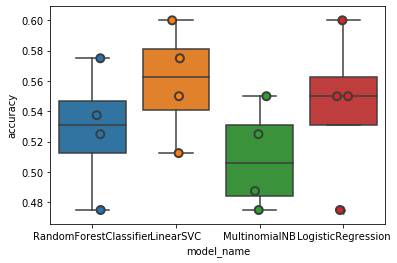

In [13]:

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

### 4.3.1. Linear SVC Model has the highest Accuracy out of the 4 models

In [14]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.559375
LogisticRegression        0.543750
MultinomialNB             0.509375
RandomForestClassifier    0.528125
Name: accuracy, dtype: float64

## 4.4. Evaluation of Linear Support Vector Machine

In [15]:
# Model Creation for the SVM classifier
model = LinearSVC()

# Split the data again into test and train
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, X_train.index, test_size=0.3, random_state=0)

# Train the model
model.fit(X_train, y_train)

# Test the model
y_pred = model.predict(X_test)


### 4.4.1. Creating a confusion matrix

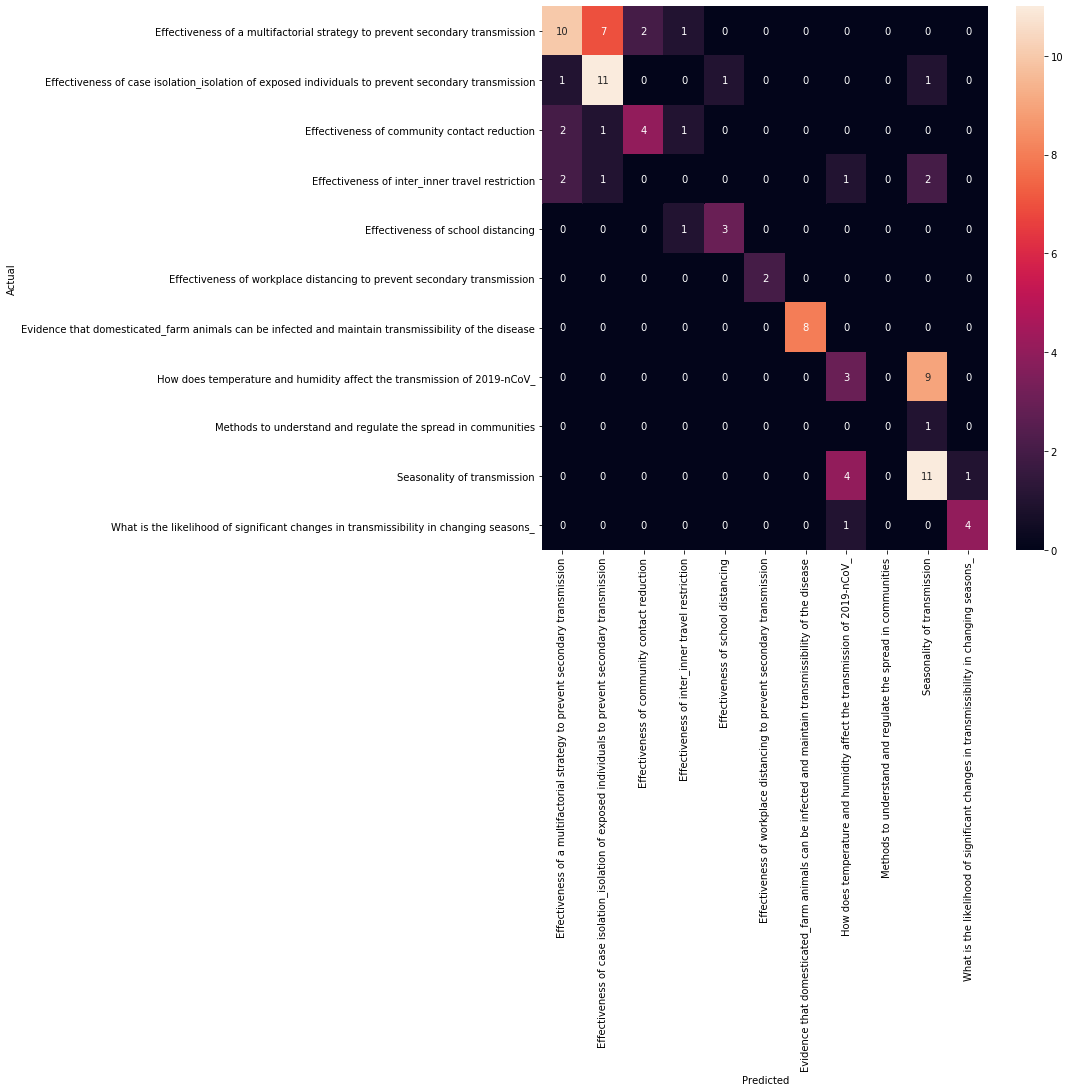

In [16]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=topic_list['research_topic'].values, yticklabels=topic_list['research_topic'].values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### 4.4.2. Creating a final Evaluation report for the model

In [17]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=topic_list['research_topic'].unique()))

                                                                                                      precision    recall  f1-score   support

                        Effectiveness of a multifactorial strategy to prevent secondary transmission       0.67      0.50      0.57        20
  Effectiveness of case isolation_isolation of exposed individuals to prevent secondary transmission       0.55      0.79      0.65        14
                                                        Effectiveness of community contact reduction       0.67      0.50      0.57         8
                                                     Effectiveness of inter_inner travel restriction       0.00      0.00      0.00         6
                                                                  Effectiveness of school distancing       0.75      0.75      0.75         4
                             Effectiveness of workplace distancing to prevent secondary transmission       1.00      1.00      1.00         2
Evide

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
